In [1]:
#Import google drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install mxnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 157 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [3]:
pip install gluoncv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 8.0 MB/s 


In [4]:
from gluoncv import model_zoo, data, utils

/usr/local/lib/python3.7/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.1` and `torch==1.12.1+cu113` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [5]:
net = model_zoo.get_model('yolo3_darknet53_voc', pretrained=True)

223070KB [00:07, 30171.53KB/s]                            


In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time

In [7]:
import mxnet as mx

Provide paths to frame you wish to match (frame_path) and the mp4 file you wish to search through (video_path).

In [8]:
video_path = ""
frame_path = ""

In [9]:
class frame_matcher:

    def comparison_bound(self, frame_path):
        x, img = data.transforms.presets.yolo.load_test(frame_path, short=512)
        class_IDs, scores, bounding_boxs = net(x)
        return(bounding_boxs[0][0])
    
    def iou_score(self, b1, b2):
        #Top left corner of the internal rectangle is the furthest right and lowest down top left corner of our two rectangles
        top_left = (max(b1[0], b2[0]), max(b1[1], b2[1]))

        #Bottom right corner of the internal triangle will just then be the furthest left and highest up corner of our two rectangles
        bottom_right = (min(b1[2], b2[2]), min(b1[3], b2[3]))


        length = bottom_right[0] - top_left[0] 
        breadth = bottom_right[1] - top_left[1]
        intersection_area = length * breadth

        #Now we just need to get union, which would be sum of area of both - area of intersection right?

        b1_length = b1[2] - b1[0] 
        b1_breadth = b1[3] - b1[1]

        b1_area = b1_length * b1_breadth

        b2_length = b2[2] - b2[0] 
        b2_breadth = b2[3] - b2[1]

        b2_area = b2_length * b2_breadth

        union_area = b2_area + b1_area - intersection_area
        return intersection_area / union_area #Hence intersection over union.

    def insert_by_iou(self, frame_bundle, frame_list):
        #Really boring and rubbish insertion into sorted list but I hate you so deal with it.
        if frame_list == []:
            return [frame_bundle]
        
        for i in range(len(frame_list)):
          if frame_list[i][0] < frame_bundle[0]:
            frame_list = frame_list[:i] + [frame_bundle] + frame_list[i:]
            return frame_list
    
        
        frame_list.append(frame_bundle)
        return frame_list 

    def frame_match(self, frame_path, video_path):
        print(frame_path)
        comparison_bound = self.comparison_bound(frame_path)
        frame_list = []

        cap = cv2.VideoCapture(video_path)
        colors=[tuple(255 * np.random.rand(3)) for i in range(5)]

        while(cap.isOpened()):
            stime= time.time()
            ret, frame = cap.read()

            if ret:
                frame = mx.nd.array(frame)
                x, img = data.transforms.presets.yolo.transform_test(frame, short=512)
                
                class_IDs, scores, bounding_boxs = net(x)
                iou = self.iou_score((bounding_boxs[0][0]), comparison_bound)

                frame_list = self.insert_by_iou((iou, img, bounding_boxs[0], scores[0], class_IDs[0]), frame_list)

                if cv2.waitKey(1)  & 0xFF == ord('q'):
                    break
            else:
                break
                
        cap.release()
        cv2.destroyAllWindows()

        return frame_list
        



In [10]:
matcher = frame_matcher()

/content/drive/MyDrive/Transition_Labeller/test_images/test_person.jpg


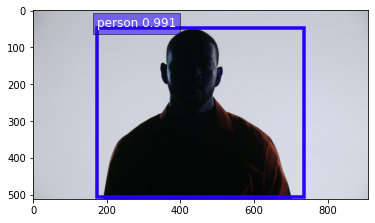

In [11]:
frame_list = matcher.frame_match(frame_path, video_path)


closest_frame = frame_list[0]
ax = utils.viz.plot_bbox(frame_list[0][1], frame_list[0][2], frame_list[0][3],
                         frame_list[0][4], class_names=net.classes)
plt.show()

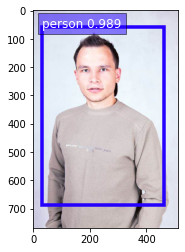

In [22]:
x, img = data.transforms.presets.yolo.load_test(frame_path, short=512)
print('Shape of pre-processed image:', x.shape)
class_IDs, scores, bounding_boxs = net(x)
  
ax = utils.viz.plot_bbox(img, bounding_boxs[0], scores[0],
                         class_IDs[0], class_names=net.classes)
plt.show()